In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

original_df = pd.read_csv("EWKino-train.csv")

In [21]:
def normalise_columns(df):
    # Normalise all columns in a dataframe
    
    mean = df.mean(axis=0)
    std = df.std(axis=0)
    df -= mean
    df /= std
    
    return mean, std, df

In [22]:
train_mean, train_std, norm_df = normalise_columns(original_df)

In [5]:
def build_model(): # Returns a compiled model, as K-fold cross validation involves building the same model lots of times
    
    model = keras.Sequential([
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(1)
    ])

    model.compile(
        optimizer=keras.optimizers.RMSprop(0.01),
        loss="mse",
        metrics=["mae"]
    )
    
    return model

In [6]:
def k_fold_validation(k, num_epochs, df): # Trains model for one round of k-fold validation
    
    shuffled_df = df.sample(frac=1)
    labels = shuffled_df.pop("DM_relic_density")
    train = shuffled_df
    num_val_samples = len(train) // k
    all_histories = []
    
    for i in range(k):
        # print(f"Processing fold #{i}")
        
        val_data = train[i * num_val_samples: (i + 1) * num_val_samples]
        val_labels = labels[i * num_val_samples: (i + 1) * num_val_samples]
        
        partial_train_data = np.concatenate(
            [train[:i * num_val_samples],
            train[(i + 1) * num_val_samples:]],
            axis=0
        )
        
        partial_train_labels = np.concatenate(
            [labels[:i * num_val_samples],
            labels[(i + 1) * num_val_samples:]],
            axis=0
        )
        
        model = build_model()
        
        history = model.fit(
            partial_train_data,
            partial_train_labels,
            epochs=num_epochs,
            validation_data=(val_data, val_labels),
            verbose=0
        )
        
        all_histories.append(history)
        
    # Average the training and validation accuracy for each epoch across the folds
    single_iter_val_accuracy = np.empty((k,num_epochs))
    single_iter_train_accuracy = np.empty((k,num_epochs))
    for i in range(k):
        single_iter_val_accuracy[i,:] = all_histories[i].history["val_mae"]
        single_iter_train_accuracy[i,:] = all_histories[i].history["mae"]
    single_iter_val_accuracy = single_iter_val_accuracy.mean(axis=0)
    single_iter_train_accuracy = single_iter_train_accuracy.mean(axis=0)
    
    return single_iter_val_accuracy, single_iter_train_accuracy

In [7]:
k = 5 # This value seems to work fine
num_epochs = 250 # When testing new models, set this high enough to see overfitting (assuming model is powerful enough to overfit)
iterations = 5 # If accuracy scores have high variance, increase iterations to 5 (smoother) or 10 (smoothest)
avg_train_accuracy = np.empty((iterations,num_epochs))
avg_val_accuracy = np.empty((iterations,num_epochs))

for i in range(iterations):
    print(f"Processing iteration #{i}")
    single_iter_val_accuracy, single_iter_train_accuracy = k_fold_validation(k, num_epochs, norm_df)
    avg_val_accuracy[i,:] = single_iter_val_accuracy
    avg_train_accuracy[i,:] = single_iter_train_accuracy
avg_val_accuracy = avg_val_accuracy.mean(axis=0)
avg_train_accuracy = avg_train_accuracy.mean(axis=0)

Processing iteration #0


2024-11-14 11:44:35.753908: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-14 11:44:35.902560: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-14 11:44:35.902625: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-14 11:44:35.905537: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-14 11:44:35.905586: I external/local_xla/xla/stream_executor

Processing iteration #1
Processing iteration #2
Processing iteration #3
Processing iteration #4


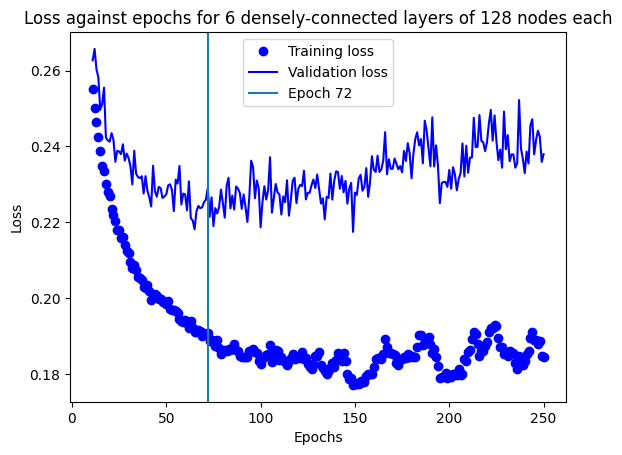

In [17]:
# Plot training and validation accuracy for each epoch

best_epoch = 72
cut = 10 # This removes first epoch (usually very incorrect) to help the graph scale correctly
epochs = range(cut+1, num_epochs + 1)
plt.plot(epochs, avg_train_accuracy[cut:], "bo", label="Training loss")
plt.plot(epochs, avg_val_accuracy[cut:], "b", label="Validation loss")
plt.axvline(best_epoch, label=f"Epoch {best_epoch}")
plt.title("Loss against epochs for 6 densely-connected layers of 128 nodes each")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("good fitting info.png")
plt.show()

In [ ]:
# Train new model on all of the available data

df = pd.read_csv("EWKino-train.csv")
df = normalise_columns(df)
labels = df.pop("DM_relic_density")
train = df

model = build_model()
        
history = model.fit(
    train,
    labels,
    epochs=72, # Change this depending on when the model starts overfitting
    verbose=0
)

In [57]:
# Read in the test file that the model has not seen
test = pd.read_csv("EWKino-test.csv")

# Normalise the columns using the same mean and std as for the train dataset - do NOT normalise using the test set itself!
test -= train_mean
test /= train_std

# Store the ground truth we are hoping to predict in targets
targets = test.pop("DM_relic_density").values

# Predict the DM relic densities using our model. Using .flatten() turns predictions into a 1D array that can be put into a dataframe
predictions = model.predict(test).flatten()

data = {'Targets': targets,
        'Predictions': predictions}

comparison_df = pd.DataFrame(data)
comparison_df.to_csv("prediction-vs-target-6layer-128node-72epoch.csv")

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


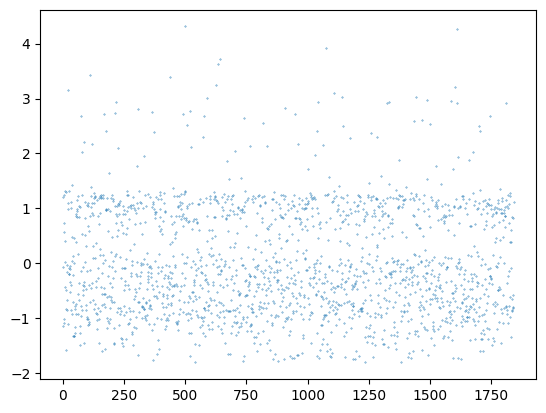

In [56]:
plt.scatter(range(len(targets)), targets, s=0.1)

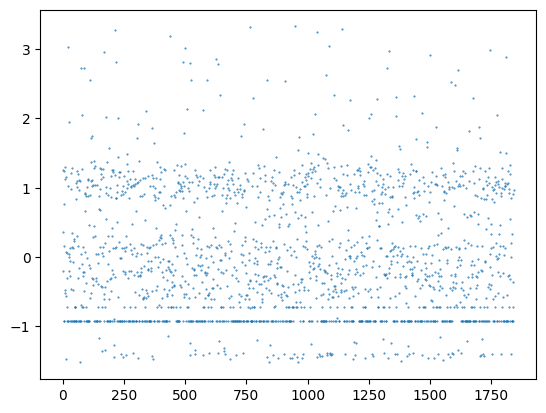

In [ ]:
plt.scatter(range(len(predictions)), predictions.sort(), s=0.2)

In [37]:
print(f"Absolute mean error: {np.abs(targets-predictions).mean()}")
print(f"Worst error: {np.abs(targets-predictions).max()}")

Absolute mean error: 0.20820291091412504
Worst error: 2.6827940065698943


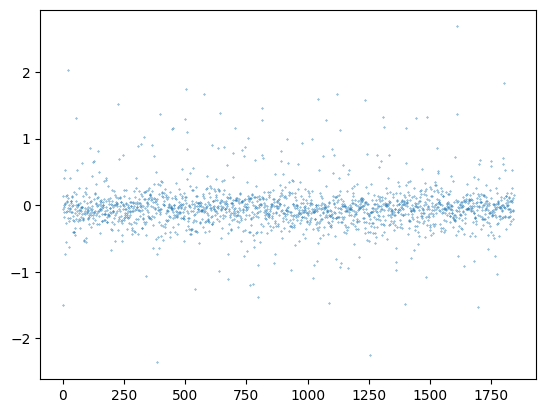

In [34]:
plt.scatter(range(len(targets)), targets-predictions, s=0.1)